In [1]:
import pandas as pd
import re
df=pd.read_csv('C:/Users/spmolab/OneDrive/Data Science/Nepal/newtweets_Nepal11Apr-9thMay_complete.txt',encoding='utf-16',sep='\t')

In [2]:
#Convert point format GPS coordinates into lat long data
def pointstrip(s):
    ss=s[s.find("[")+1:s.find("]")]
    coord=ss.split(',')
    lat=float(coord[0])
    long=float(coord[1].strip())
    return lat,long

lat=[]
long=[]
for i in range(len(df)):
    temp=df['GPS'][i]
    coord=pointstrip(temp)
    lat.append(coord[0])
    long.append(coord[1])
df['lat']=lat
df['long']=long

In [3]:
#set the index of the dataframe to date&time
db=df #create a copy

In [4]:
#extract map of Nepal
from shapely.geometry import Polygon
map_Nepal=pd.read_csv('C:/Users/spmolab/OneDrive/Data Science/Nepal/NP_L0.csv')

stri=map_Nepal.WKT[0]

#parsing
m = stri.split('((', 1)[1].split('))')[0]
m = m.split(',')
m = [list(map(float,item.split(' '))) for item in m]

#construct a polygon and extract coordinates
poly_Nepal=Polygon(m)
nepal_long=[item[0] for item in m]
nepal_lat=[item[1] for item in m]

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


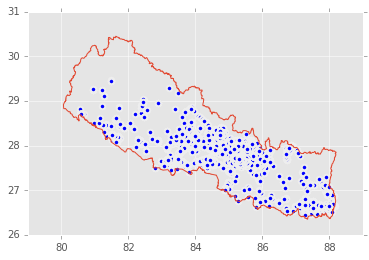

In [5]:
## Extract geospatial data from a particular timeframe and plot it
#plot the current GPS points
import matplotlib.pyplot as plt
from matplotlib import style
%pylab inline
style.use('ggplot')
import numpy as np

#extract geo points from a specific timeframe
segment=df
new_lat=[item for item in segment.lat]
new_long=[item for item in segment.long]

#plot borders of Nepal along with extracted points
plt.plot(nepal_long,nepal_lat)
plt.scatter(new_long,new_lat,s=30,linewidths=2)
plt.show()

In [6]:
##Define routines which will help implement density based clustering
from sklearn.cluster import DBSCAN
import numpy as np
import math
from scipy.spatial import distance
from geopy.distance import vincenty

#Finding maximum distance between lat,long points in a list
def maxdist(coords): 
    dists=distance.cdist(coords,coords,'euclidean') #Create distance matrix of coordinates (using)
    
    #Code to find out the two locations with maximum distance between them
    l=np.argmax(dists)
    length=len(coords)
    k=floor(l/length)
    z=(l)%length
    k=k.astype(int)
    
    #find distance
    max=vincenty(coords[k],coords[z]).kilometers
    return max

#Reference : http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/


#Use DBC to reduce dataset into clusters of a particular size
def clust_reduce(X,XX,min_clust_size,model_max_dist,max_dist):
#radius is in km    
#X is a 2D array with lat,long
#XX is a 2D array with lat,long and 2 other columns
#clust_size is the minimum number of elements in a cluster
#model_max_radius is the max distance DBC uses to group clusters together
#max_dist is the maximum distance between points tolerable in a cluster
    Y=X[:]
    YY=XX[:]
    #Calculation of parameters for the haversine metric
    kms_per_radian = 6371
    epsilon = model_max_dist / kms_per_radian
    
    #Clustering routine
    model = DBSCAN(eps=epsilon, min_samples=min_clust_size, algorithm='ball_tree',metric='haversine').fit(np.radians(Y))
    cl_labels=model.labels_

#Segregate clusters greater and smaller than required radius
    clust_temp=[] #Temp variable for storing lat, long of points in each cluster
    clust_indx=[] #Temp variable for storing index associated with each points in each cluster
    clust_temp_full=[] #Temp variable for storing lat, long of points, and 2 other associated variables in each cluster
    
    #Load all clusters into a nested list
    for ilabel in range(0,max(set(cl_labels))+1):
        temp=[(Y[i][0],Y[i][1]) for i in range(len(cl_labels))if cl_labels[i]==ilabel]
        temp_full=[(YY[i][0],YY[i][1],YY[i][2],YY[i][3]) for i in range(len(cl_labels))if cl_labels[i]==ilabel]
        tempindx=[i for i in range(len(cl_labels))if cl_labels[i]==ilabel]
        clust_temp.append(temp)
        clust_indx.append(tempindx)
        clust_temp_full.append(temp_full)
        
    
    clustdis=[(maxdist(item)) for item in clust_temp] #calculate max seperation of points
    
    #segregate points into clusters which are smaller than specified size and those which are bigger
    qualified_clusters=[]
    delindex=[]
    qualified_clusters_full=[]
    for i in range(len(clustdis)):
        if clustdis[i]<max_dist:
            qualified_clusters.append(clust_temp[i])
            delindex.append(clust_indx[i])
            qualified_clusters_full.append(clust_temp_full[i])
    flat_delindex = [x for sublist in delindex for x in sublist] #flatten the nested list of indices

    no_unq_clusters=len(clust_temp)-len(qualified_clusters)-1
    #Remove points belonging to clusters which are less than 5km from main data
    for index in sorted(flat_delindex, reverse=True):
        del Y[index]
        del YY[index]
    return qualified_clusters,qualified_clusters_full,Y,YY,no_unq_clusters
#returns qualified_clusters (lat,long) as an array, qualified_clusters_full (lat,long + 2 additional attributes) as an array
# Y (list of unqualified lat,long points), YY (list of unqualified lat,long points with two additional parameters)
# no_unq_clusters (no of unqualified clusters:  where points were further apart than the defined limit)

In [7]:
#Generate random color
def rcolor(n):
    import random
    col=[]
    for i in range(n):
        r = lambda: random.randint(0,255)
        temp=('#%02X%02X%02X' % (r(),r(),r()))
        col.append(temp)
    return col

Total number of points: 34093
Total number of clusters identified: 499
Total number of unqualified clusters: 1
Total number of points that could not be clustered 19338


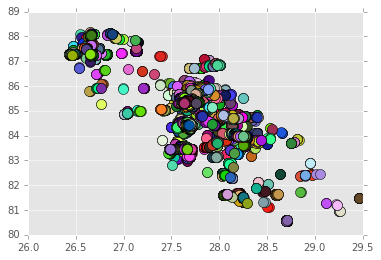

In [8]:
#duplicate the pandas object to store as a reference
segment=df

#extract neccesary parameters from the pandas object in an array to use as an argument in the DBC algorithm
new_lat=[item for item in segment.lat]
new_long=[item for item in segment.long]
X=[(segment.lat[i],segment.long[i]) for i in range(len(segment))]
XX=[(segment.lat[i],segment.long[i],segment.Date[i],segment.Text[i]) for i in range(len(segment))]
Y=X[:]
YY=XX[:]


print("Total number of points:",len(Y))
qual_clust=[]
qual_clust_full=[]
no_unq_clust=5
#max distance to which DBC will cluster together points
lamba=5

#loop in order to 
#1) use DBC to do clustering according to defined lambda
#2) few clusters will have points that are farther away than defined lambda, identify those clusters
#3) do DBC again on those clusters by reducing lambda
while no_unq_clust>1:
    temp_qual_clust,temp_qual_clust_full,Y,YY,no_unq_clust=clust_reduce(Y,YY,2,lamba,5)
    for item in temp_qual_clust:
        qual_clust.append(item)
    for item in temp_qual_clust_full:
        qual_clust_full.append(item)    
    lamba=lamba*0.9


print("Total number of clusters identified:",len(qual_clust))
print("Total number of unqualified clusters:",no_unq_clust)


plt.close('all')
for item in qual_clust:
    clust_lat=[point[0] for point in item]
    clust_long=[point[1] for point in item]
    temp_color=rcolor(1)[0]
    plt.plot(clust_lat,clust_long,marker='o',markerfacecolor=temp_color,markersize=10)

print("Total number of points that could not be clustered",len(Y))

In [9]:
import math
#Method on how to calculate a midpoint from a set of spatial points. http://www.geomidpoint.com/calculation.html
#This would be used to define clusters by their mean lat,long
#Imp note: this method won't work if points cross international date-line
def midpoint(p):

    lat=[item[0]*3.142/180 for item in p]
    long=[item[1]*3.142/180 for item in p]
    X=[]
    Y=[]
    Z=[]
    for i in range(len(lat)):
        tempX=math.cos(lat[i])*math.cos(long[i])
        tempY=math.cos(lat[i])*math.sin(long[i])
        tempZ=math.sin(lat[i])
        X.append(tempX)
        Y.append(tempY)
        Z.append(tempZ)
    Xmean=mean(X)
    Ymean=mean(Y)
    Zmean=mean(Z)
    midlon=math.atan2(Ymean,Xmean)*180/3.142
    hyp=sqrt(Xmean*Xmean + Ymean*Ymean)
    midlat=math.atan2(Zmean,hyp)*180/3.142
    return midlat,midlon

In [10]:
#Calculate spatial midpoints of all clusters and find the number of tweets before and after the earthquake from that cluster
mid=[] #variable to store spatial midpoint
before=[] #variable to store number of tweets before the earthquake
after=[]#variable to store number of tweets after the earthquake

#note: tweets on 24,25,26 of April are excluded from this analysis because a lot of users only come online to tweet on these days
# and thus skew the analysis

for item in qual_clust_full:
    if len(item)>3:
        geo=[]
        tweets_before_quake=len([i for subitem in item if subitem[2]<'4/23/2015'])
        before.append(tweets_before_quake)
        tweets_after_quake=len([i for subitem in item if subitem[2]>'4/27/2015'])
        after.append(tweets_after_quake)

for item in qual_clust:
    if len(item)>3:
        geoa=midpoint(item)
        mid.append(geoa)

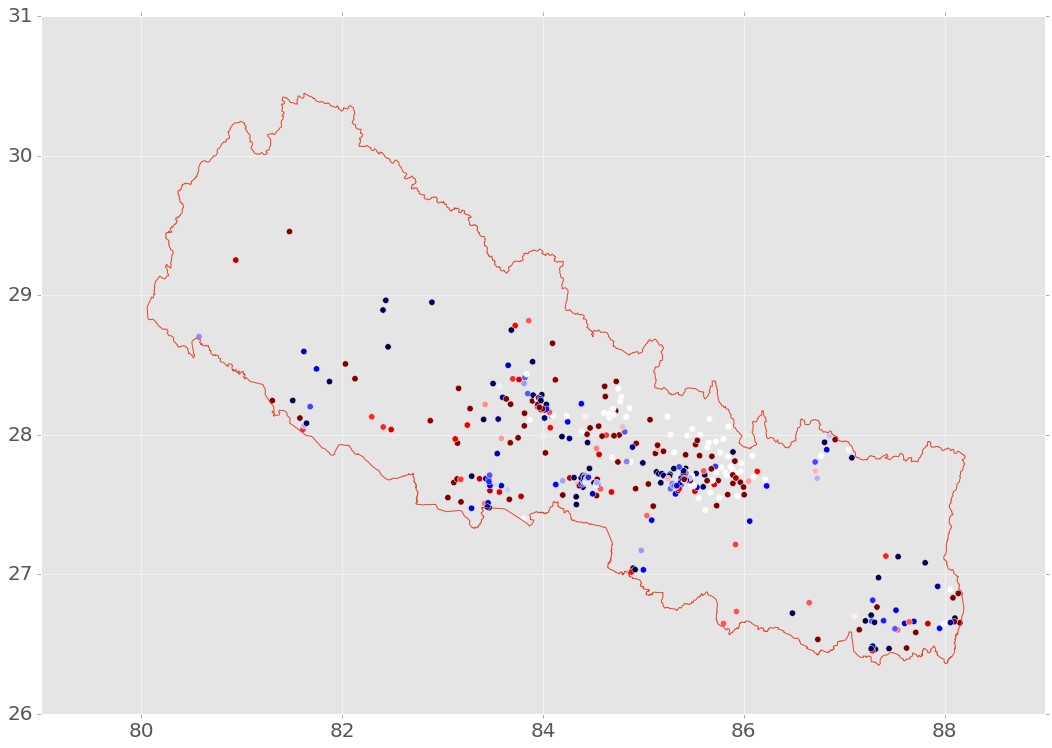

In [11]:
#calculation of percentage of tweets after the earthquake out of total tweets
per_change = []
for i in range(len(mid)):
    if after[i] + before[i] > 0:
        chge = (after[i]) / (after[i] + before[i]) * 100 
        # chge has range (0,100); <50 means more tweets before; >50 means more tweets after; 
        per_change.append(chge)
    elif after[i] + before[i] == 0:
        per_change.append(50)
plt.figure(figsize=(18, 12.5))
plt.plot(nepal_long, nepal_lat)

y_lat = [item[0] for item in mid]
x_long = [item[1] for item in mid]
plt.scatter(x=x_long, y=y_lat, c=per_change, cmap='seismic', vmin=0, vmax=100, s=40)
plt.tick_params(axis='both', which='major', labelsize=20)

In [18]:
savedb=pd.DataFrame(columns=['Lat','Long','Before','After'])
savedb.Lat=y_lat
savedb.Long=x_long
savedb.Before=before
savedb.After=after

In [20]:
clust_lat=[]
clust_long=[]
clust_date=[]
clust_text=[]
clust_label=[]
ind=0
for item in qual_clust_full:
    for subitem in item:
        clust_lat.append(subitem[0])
        clust_long.append(subitem[1])
        clust_date.append(subitem[2])
        clust_text.append(subitem[3])
        clust_label.append(ind)
    ind=ind+1

In [21]:
savedb2=pd.DataFrame(columns=['Lat','Long','Date','Text','Index'])
savedb2.Lat=clust_lat
savedb2.Long=clust_long
savedb2.Date=clust_date
savedb2.Text=clust_text
savedb2.Index=clust_label

In [22]:
savedb2.to_csv('clusters_complete.txt',encoding='utf-8')